In [1]:
import sys
import time

import itertools
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from pandas import ewma
from tqdm import tqdm_notebook as tqn
from IPython.display import clear_output
%matplotlib inline
from batch_gen import SixNumbersBatch
sys.path.append('../..')
import utils
from dataset import Dataset, B, V, Pipeline
from dataset.opensets import MNIST
from dataset.models.tf import Inception_v4, DenseNet169, ResNet101, MobileNet, SqueezeNet
from dataset.models.tf import DenseNet121, ResNet50, ResNetAttention92, VGG19, ResNetAttention56

In [2]:
dset = MNIST(batch_class=SixNumbersBatch)

ExtractingExtractingExtracting   Extracting/tmp/train-images-idx3-ubyte.gz/tmp/train-labels-idx1-ubyte.gz/tmp/t10k-images-idx3-ubyte.gz


 /tmp/t10k-labels-idx1-ubyte.gz


In [3]:
ppl = (Pipeline()
       .gluing_of_images()
       .resize(shape=(128, 320))
       .normalize_images()
       .one_hot())

In [4]:
models = [Inception_v4, DenseNet169, ResNet101, MobileNet, SqueezeNet,\
          DenseNet121, ResNet50, ResNetAttention92, VGG19, ResNetAttention56]
models_names = ['Inception_v4', 'DenseNet169', 'ResNet101', 'MobileNet', 'SqueezeNet',\
                'DenseNet121', 'ResNet50', 'ResNetAttention92', 'VGG19', 'ResNetAttention56']
models_dict = dict(zip(models_names, models))

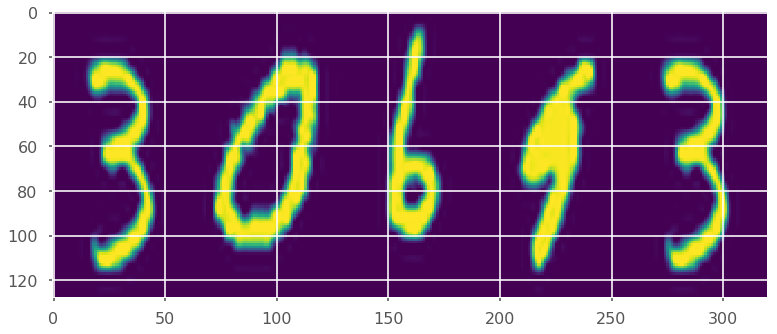

In [5]:
b = (ppl<<dset.train).next_batch(15)
plt.imshow(b.images[0].reshape(128,320))

In [6]:
def reshape_loss(target, predictions):
    target = tf.reshape(target, [-1, 5, 10])
    predictions = tf.reshape(predictions, [-1, 5, 10])
    return tf.losses.softmax_cross_entropy(target, predictions)

In [7]:
inputs_config = {
    'images': {'shape':(128, 320, 1)},
    'labels':{'shape':(50), 'name':'targets'}
}

config = {
    'inputs':inputs_config,
    'optimizer': 'Adam',
    'loss': reshape_loss,
    'input_block/inputs': 'images',
    'head/units': 50,
    'output': dict(ops=['labels', 'proba', 'accuracy'])}

feed_dict = {
    'images': B('images'),
    'labels': B('labels')
}

In [8]:
def get_ppl(model, name):
    train_ppl = ((ppl<<dset.train)
                        .init_variable('model', model)
                        .init_variable('loss', init_on_each_run=list)
                        .init_model('dynamic',
                                    V('model'),
                                    name,
                                    config=config)
                       .train_model(name,
                                    fetches='loss',
                                    feed_dict=feed_dict,
                                    save_to=V('loss'), mode='a'))
    test_ppl = ((ppl<<dset.test)
                        .init_variable('proba', init_on_each_run=list)
                        .init_variable('target', init_on_each_run=list)
                        .import_model(name, train_ppl)
                        .predict_model(name,
                                      fetches=['output_proba',
                                               'targets'],
                                      feed_dict=feed_dict,
                                      save_to=[V('proba'), V('target')], mode='a'))
    return train_ppl, test_ppl

In [9]:
def calc_acc(targets, proba):
    proba = proba.reshape(-1, 5, 10)
    targets = targets.reshape(-1, 5, 10)
    proba = np.argmax(proba, axis=-1)
    targets = np.argmax(targets, axis=-1)
    return len(np.where(proba.reshape(-1) == targets.reshape(-1))[0])/len(targets.reshape(-1))

In [10]:
for name, model in models_dict.items():
    print(name)
    train_ppl, test_ppl = get_ppl(model, name)
    for i in tqn(range(8000)):
        train_ppl.next_batch(10, n_epochs=None, suffle=True)
        test_ppl.next_batch(10, n_epochs=None, suffle=True)
        proba = test_ppl.get_variable('proba')[-1]
        target = test_ppl.get_variable('target')[-1]

    train_ppl.save_model(name, path=name)

In [11]:
for name, model in tqn(models_dict.items()):
    print('Start loading %s model'%(name))
    config['load'] = {'path':'./%s/'%(name)}
    t = time.time()
    loaded_model = model(config=config)
    print('Model %s was loaded. Loading time: %.2f\n'%(name, time.time() - t))
    test_ppl = ((ppl<<dset.test)
                .init_variable('proba', init_on_each_run=list)
                .init_variable('targets', init_on_each_run=list)
                .import_model(name, loaded_model)
                .predict_model(name,
                              fetches=['output_proba','targets'],
                              feed_dict=feed_dict,
                              save_to=[V('proba'), V('targets')], mode='a'))
    for i in range(6):
        batch = test_ppl.next_batch(60)

    true_numbers = np.array(test_ppl.get_variable('targets'))
    predict = np.array(test_ppl.get_variable('proba'))
    print('%s accuracy: %.2f\n\n'%(name, calc_acc(true_numbers, predict)))
    tf.reset_default_graph()

Start loading Inception_v4 model
INFO:tensorflow:Restoring parameters from ./Inception_v4/model-8000
Model Inception_v4 was loaded. Loading time: 205.71

Inception_v4 accuracy: 0.97


Start loading VGG19 model
INFO:tensorflow:Restoring parameters from ./VGG19/model-8000
Model VGG19 was loaded. Loading time: 4.06

VGG19 accuracy: 0.98


Start loading ResNet101 model
INFO:tensorflow:Restoring parameters from ./ResNet101/model-8000
Model ResNet101 was loaded. Loading time: 83.00

ResNet101 accuracy: 0.93


Start loading ResNetAttention56 model
INFO:tensorflow:Restoring parameters from ./ResNetAttention56/model-8000
Model ResNetAttention56 was loaded. Loading time: 101.25

ResNetAttention56 accuracy: 0.38


Start loading DenseNet121 model
INFO:tensorflow:Restoring parameters from ./DenseNet121/model-8000
Model DenseNet121 was loaded. Loading time: 347.31

DenseNet121 accuracy: 0.99


Start loading MobileNet model
INFO:tensorflow:Restoring parameters from ./MobileNet/model-8000
Model Mobile

In [12]:
def draw(ind):
    for i in range(3):
        plt.imshow(image[ind[i]])
        plt.grid()
        plt.title('Graph №{} \nNetwork prediction: {} {} {} {} {}'.format(i, *predict[ind[i]]) \
                             + '\nreal answer: {} {} {} {} {}'.format(*targets[ind[i]]))
        plt.show()

# Примеры без ошибок

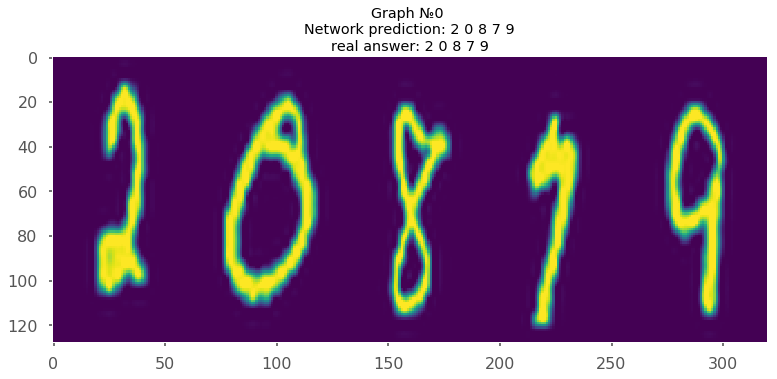

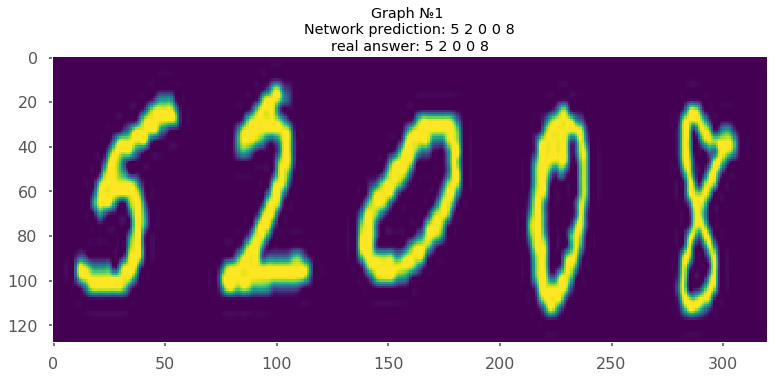

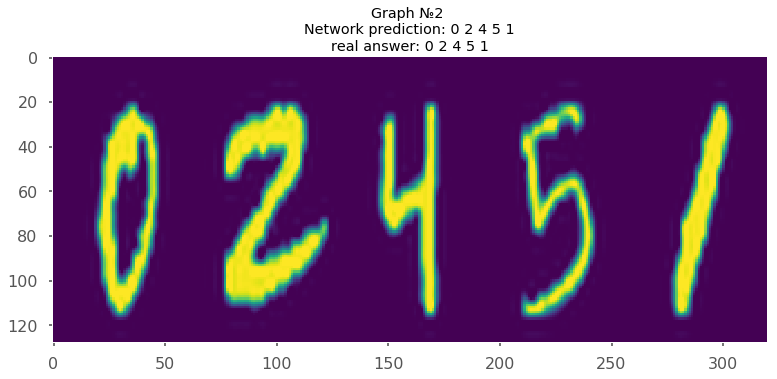

In [83]:
ind = np.random.choice(indx_true, 3)
draw(ind)

# Примеры с ошибками

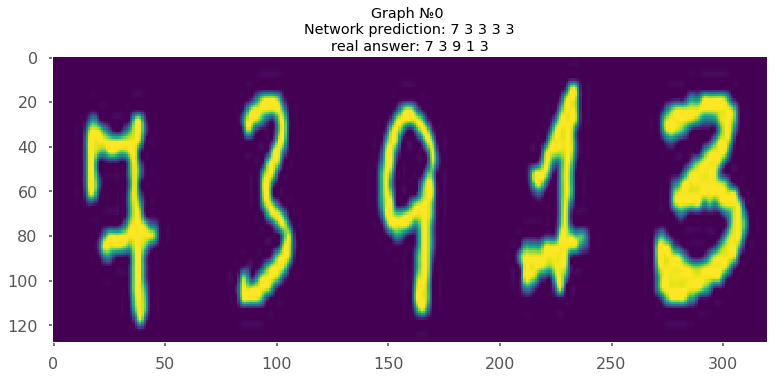

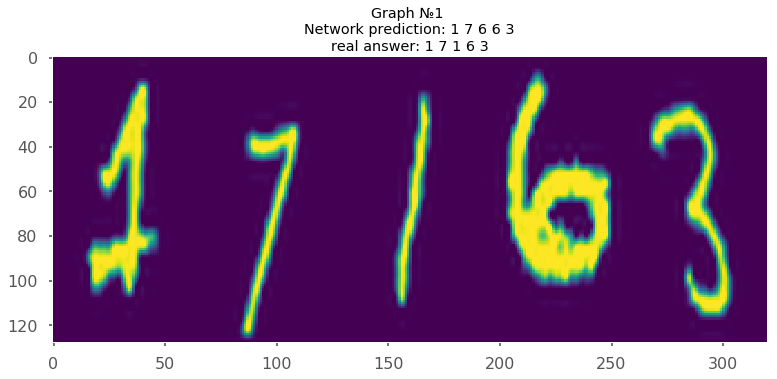

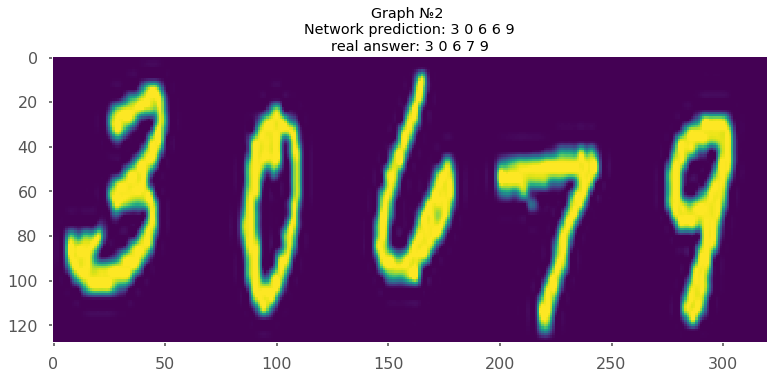

In [82]:
ind = np.random.choice(indx_false, 3)
draw(ind)